In [2]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns

import os
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme()


In [78]:
# specify the directory where the CSV files are located
directory = 'data/30x1'
N_spins = 30
BJ = 50
N_hidden = 8
N_embedding = 4
filter_string = f'500-{BJ}-{N_spins}'#all test data was created in 2023
dfs = []
count = 0
# training_data
for filename in os.listdir(directory):
    
    if filename.endswith('.csv') and filter_string in filename:
        # load the CSV file into a pandas DataFrame
        p = os.path.join(directory,filename)
        try:
            df = pd.read_csv(p,sep=';', decimal=",", header=None, skiprows=1)
        except:
            pass
        # do something with the DataFrame
        if len(df) != 500:
            continue
        dfs.append(df)
        
        count +=1
        if count == 500:
            break


print("Done")
num_files = len(dfs)
print(num_files)

Done
217


In [79]:
print(dfs)

[       0           1   2            3  \
0      0   15.000000  -2     0.000000   
1      1   54.993684  -4     0.000000   
2      2   14.996842  -2     0.009474   
3      3   10.996842  -2     0.026054   
4      4   14.971579  -2     0.026054   
..   ...         ...  ..          ...   
495  495 -400.822362 -18 -1983.409116   
496  496 -444.873676 -20 -1983.480167   
497  497 -444.928941 -20 -1983.535433   
498  498 -444.968418 -20 -1983.574909   
499  499 -404.992894 -18 -1983.596227   

                                                     4  
0     -1,1,1,-1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1...  
1     -1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1...  
2     -1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1...  
3     -1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-...  
4     -1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1...  
..                                                 ...  
495   1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,...  
496   1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1

In [80]:
data = np.zeros((num_files,500,N_spins,1))

for trajectory_index in range(0,len(dfs)):
    for iteration_index in range(500):
        obj = np.array(dfs[trajectory_index].loc[iteration_index,4].split(',')).reshape((N_spins,1))
        for line in range(10):
            for row in range(1):
                        data[trajectory_index,iteration_index,line,row] = float(obj[line,row])



                        
print("Done")


Done


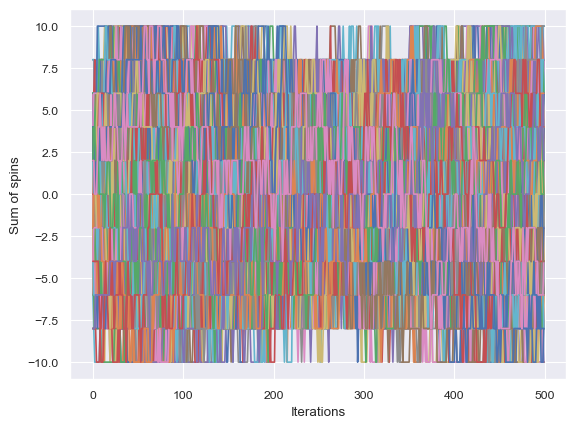

In [81]:
plt.plot(data.sum(axis=-1).sum(axis=-1).T)
plt.xlabel("Iterations")
plt.ylabel("Sum of spins")
plt.show()

In [82]:
# Here I'll create some dummy numpy data with similar dimensionality as your data

trajectories_numpy_raw = data.reshape(-1, 500, N_spins*1)#np.random.normal(size=(100, 500, 32, 32))
# trajectories_numpy_raw = trajectories_numpy_raw.transpose([0,2,1])

print("The data should have shape:", trajectories_numpy_raw.shape)
print("Which corresponds to [T x F x D^2]: 10 independent trajectories (T), 500 frames in each trajectory (F) for a system of size 32 x 32 (D^2)")

The data should have shape: (217, 500, 30)
Which corresponds to [T x F x D^2]: 10 independent trajectories (T), 500 frames in each trajectory (F) for a system of size 32 x 32 (D^2)


In [83]:
# lets reverse some trajectory and get labels to train on

# Draw indices to flip
toFlip = np.random.choice([0,1], size=trajectories_numpy_raw.shape[0]).astype(bool)

# flip
trajectories_numpy = trajectories_numpy_raw.copy()
trajectories_numpy[toFlip] = np.flip(trajectories_numpy[toFlip], 1)

# Create Labels
labels_numpy = np.zeros(trajectories_numpy.shape[0]).reshape(-1,1)
labels_numpy[toFlip == 0] = 1

print("\nThe labels should have shape:", labels_numpy.shape)
print("Which corresponds to [T x 1]: The one in the last dimension is VERY important, use .reshape(-1,1) if you lose it at some point.")

print("\nThe labels indicate if a trajectory is in correct direction (1) or reversed (0)")



The labels should have shape: (217, 1)
Which corresponds to [T x 1]: The one in the last dimension is VERY important, use .reshape(-1,1) if you lose it at some point.

The labels indicate if a trajectory is in correct direction (1) or reversed (0)


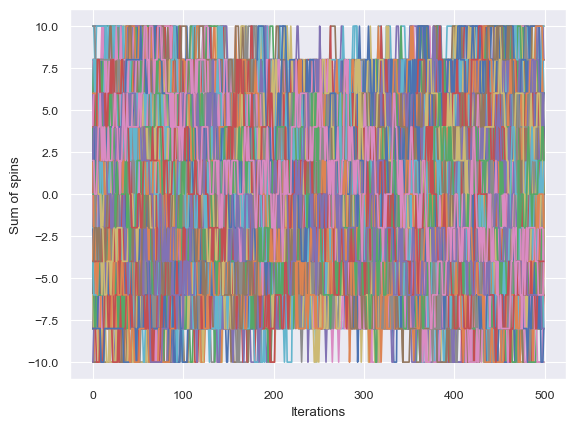

In [84]:
plt.plot(trajectories_numpy.sum(axis=-1).T)
plt.xlabel("Iterations")
plt.ylabel("Sum of spins")
plt.show()

In [85]:
# Convert to pytorch tensor

trajectories_tensor = torch.from_numpy(trajectories_numpy.astype(np.float32))
labels_tensor = torch.from_numpy(labels_numpy.astype(np.float32))


In [86]:
# Let's define some neural networks

# First up a simple feedforward network, with some hidden layers and 
# a sigmoid activation in the end to restrict the ouput between 0 and 1

class MLP(nn.Module):
    def __init__(self,  trajectory_length, N_spins, input_size, hidden_size, batch_size=64):
        super(MLP, self).__init__()
        
        self.activation = nn.ReLU()

        modules = []

        modules.append(nn.Linear(N_spins * 1, 128))
        modules.append(self.activation)
        modules.append(nn.Dropout(0.1))
        modules.append(nn.Linear(128, batch_size))
        modules.append(self.activation)
        modules.append(nn.Dropout(0.1))
        modules.append(nn.Linear(batch_size, hidden_size))
        modules.append(self.activation)
        modules.append(nn.Dropout(0.1))
        self.net = nn.Sequential(*modules)

        modules = []
        modules.append(nn.Linear(trajectory_length * hidden_size, 1))
        modules.append(nn.Sigmoid())
        self.netout = nn.Sequential(*modules)

    def forward(self, X):   

        X = self.net(X)

        X = X.reshape(X.shape[0], -1)

        return self.netout(X)



# secondly a VERY simple convolutional network with a 3x3 filter reducing 
# the frames (channels) and a linear layer for the output

class CNN(nn.Module):
    def __init__(self, trajectory_length, N_spins, N_channels_hidden = 10):
        super(CNN, self).__init__()
        
        self.activation = nn.ReLU()

        modules_cnn = []

        modules_cnn.append(nn.Conv1d(trajectory_length, N_channels_hidden, 3))
        modules_cnn.append(self.activation)
        modules_cnn.append(nn.Dropout(0.1))

        modules_cnn.append(nn.Conv1d(N_channels_hidden, 1, 3))
        modules_cnn.append(self.activation)
        modules_cnn.append(nn.Dropout(0.1))


        modules_linear = []
        modules_linear.append(nn.Linear((N_spins)*(1)-4, 1))
        modules_linear.append(nn.Sigmoid())


        self.net = nn.Sequential(*modules_cnn)
        self.linear_net = nn.Sequential(*modules_linear)

    def forward(self, X):

        X = self.net(X)

        X = X.reshape(X.shape[0], X.shape[2])
        
        return self.linear_net(X)

In [87]:
# Create a dataset
full_dataset = torch.utils.data.TensorDataset(trajectories_tensor, labels_tensor)

# Split into test and training data
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [int(len(full_dataset) * 0.8), len(full_dataset) - int(len(full_dataset) * 0.8)])

# Create a data loader for train and test sets
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

In [88]:

# Our train loop, very similar to the example on the pytorch website

def train_model(N_epochs, model, train_dataloader, test_dataloader):

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    loss_history = []
    for epoch in range(N_epochs):

        train_losses, test_losses = [], []

        for i, (data, labels) in enumerate(train_dataloader):
            
            optimizer.zero_grad()
            
            y_pred = model(data)

            loss = criterion(y_pred, labels )
            
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
        

        with torch.no_grad():
            
            accuracy = 0
            for i, (data, labels) in enumerate(test_dataloader):
                    
                y_pred = model(data)
                loss = criterion(y_pred, labels )

                accuracy += (y_pred.round() == labels).sum().item()
                
                test_losses.append(loss.item())

        accuracy /= len(test_dataloader.dataset)

        loss_history.append([np.average(train_losses), np.average(test_losses), accuracy])

        print("Epoch {:04d}/{}: Train Loss: {:.4f} | Test Loss: {:.4f}\tAcc.: {:.4f} ".format(epoch, N_epochs, np.average(train_losses), np.average(test_losses), accuracy))

    return np.array(loss_history)

In [89]:
arr = []
model = MLP(trajectory_length=500, N_spins=N_spins, input_size=2, hidden_size=N_hidden, batch_size=N_embedding)
# train the model for 10 epochs
loss_history = train_model(15, model=model, train_dataloader=train_dl, test_dataloader=test_dl)
arr.append([loss_history[-1]])

Epoch 0000/15: Train Loss: 0.6939 | Test Loss: 0.6967	Acc.: 0.4545 
Epoch 0001/15: Train Loss: 0.6954 | Test Loss: 0.6989	Acc.: 0.4545 
Epoch 0002/15: Train Loss: 0.6912 | Test Loss: 0.7028	Acc.: 0.4545 
Epoch 0003/15: Train Loss: 0.6910 | Test Loss: 0.6938	Acc.: 0.4773 
Epoch 0004/15: Train Loss: 0.6913 | Test Loss: 0.6970	Acc.: 0.5227 
Epoch 0005/15: Train Loss: 0.6920 | Test Loss: 0.6980	Acc.: 0.4091 
Epoch 0006/15: Train Loss: 0.6927 | Test Loss: 0.7000	Acc.: 0.4773 
Epoch 0007/15: Train Loss: 0.6906 | Test Loss: 0.6984	Acc.: 0.4318 
Epoch 0008/15: Train Loss: 0.6903 | Test Loss: 0.7027	Acc.: 0.4545 
Epoch 0009/15: Train Loss: 0.6894 | Test Loss: 0.6973	Acc.: 0.4773 
Epoch 0010/15: Train Loss: 0.6937 | Test Loss: 0.7039	Acc.: 0.4545 
Epoch 0011/15: Train Loss: 0.6911 | Test Loss: 0.7024	Acc.: 0.4545 
Epoch 0012/15: Train Loss: 0.6901 | Test Loss: 0.7011	Acc.: 0.4545 
Epoch 0013/15: Train Loss: 0.6939 | Test Loss: 0.7028	Acc.: 0.4545 
Epoch 0014/15: Train Loss: 0.6920 | Test Loss: 0

In [90]:
# arr = []
# batch_sizes = [8,16,32,64] #batch size for the second filter
# for i in range(2,9): #number of hidden layers
#     for j in range(10,20): #training epochs
#         for k in batch_sizes:

#             # Define a model
#             #model = CNN(trajectory_length=500, N_spins=32, N_channels_hidden=10)
#             model = MLP(trajectory_length=500, N_spins=N_spins, input_size=2, hidden_size=N_hidden, batch_size=N_embedding)
#             # train the model for 10 epochs
#             loss_history = train_model(j, model=model, train_dataloader=train_dl, test_dataloader=test_dl)
#             arr.append([i,j,k, loss_history[-1]])

In [91]:

sorted_arr = sorted(arr, key=lambda x: x[-1])
last_value = 0
for s in sorted_arr[-1::]:
    print(s)
    last_value = s[-1][-1]
    

[array([0.69203532, 0.70734972, 0.45454545])]


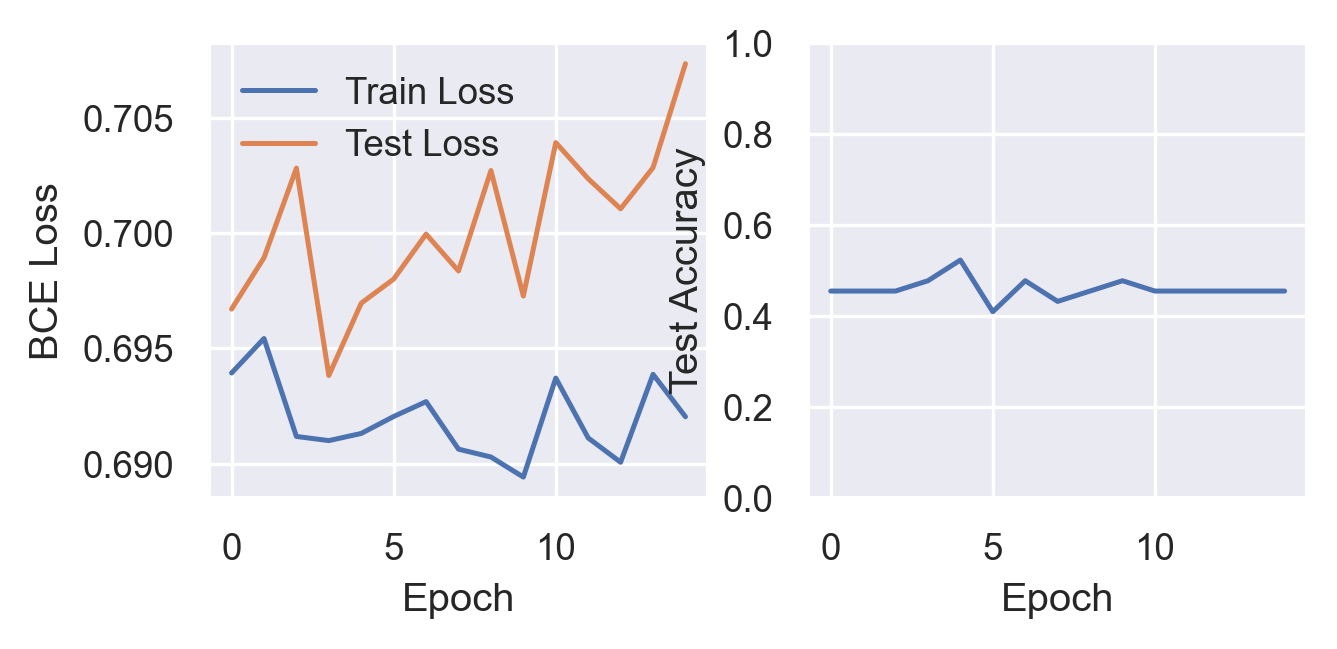

In [92]:
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_context("paper")
mpl.rcParams.update({'font.size': 5})

fig_size = (12 * 0.393701, 5 * 0.393701) # cm -> inch: 0.393701 

fig, ax = plt.subplot_mosaic([["losses", "accuracy"]],
    
                               figsize = fig_size, dpi = 300,
                               )

ax["losses"].plot(loss_history[:,0], label="Train Loss")
ax["losses"].plot(loss_history[:,1], label="Test Loss")

ax["losses"].legend(frameon=False)
ax["losses"].set_xlabel("Epoch")
ax["losses"].set_ylabel("BCE Loss")


ax["accuracy"].plot(loss_history[:,2])

ax["accuracy"].set_ylim(0, 1)
ax["accuracy"].set_xlabel("Epoch")
ax["accuracy"].set_ylabel("Test Accuracy")
with open("data.txt", "a") as myfile:
    myfile.write(f"{N_spins} {BJ} {N_hidden} {N_embedding} {last_value} \n")
